In [2]:
import pandas as pd
import numpy as np

# Load your final dataset (adjust path)
df = pd.read_csv("../data/final_job_match_dataset.csv")

# Quick required columns check
required = [
    "position_id","user_id","jobtitle_raw","soc_code_final",
    "match_score_tfidf_v2","edu_match_score","exp_match_score","train_match_score",
    "match_score_final"
]
missing = [c for c in required if c not in df.columns]
print("Missing required cols:", missing)

# Basic summary
print(df[["match_score_tfidf_v2","edu_match_score","exp_match_score","train_match_score","match_score_final"]].describe())
print("\nShare missing soc_code_final:", df["soc_code_final"].isna().mean())


Missing required cols: []
       match_score_tfidf_v2  edu_match_score  exp_match_score  \
count           3182.000000      3346.000000      3346.000000   
mean               0.130753         0.750490         0.869590   
std                0.091380         0.250200         0.241775   
min                0.000000         0.000000         0.000000   
25%                0.069442         0.500000         0.846475   
50%                0.111818         0.821232         1.000000   
75%                0.175231         1.000000         1.000000   
max                0.571442         1.000000         1.000000   

       train_match_score  match_score_final  
count        3346.000000        3182.000000  
mean            0.936327           0.412368  
std             0.168620           0.097007  
min             0.000000           0.095222  
25%             1.000000           0.352560  
50%             1.000000           0.428189  
75%             1.000000           0.473098  
max             1.00

In [3]:
# 1) Recompute final score and compare
df["match_score_final_recalc"] = (
    0.60 * df["match_score_tfidf_v2"].fillna(0) +
    0.20 * df["edu_match_score"].fillna(0.5) +
    0.15 * df["exp_match_score"].fillna(0.5) +
    0.05 * df["train_match_score"].fillna(0.5)
)

diff = (df["match_score_final"] - df["match_score_final_recalc"]).abs()
print("Max abs diff:", diff.max())
print("Mean abs diff:", diff.mean())
print("Share diffs > 1e-6:", (diff > 1e-6).mean())

assert diff.max() < 1e-6, "Final score doesn't match formula — merge/order issue."
print("✅ Final score matches formula.")


Max abs diff: 1.1102230246251565e-16
Mean abs diff: 3.453746123509827e-17
Share diffs > 1e-6: 0.0
✅ Final score matches formula.


In [4]:
# Expect: exact matches should on average score higher than fuzzy/role fallback.
if "match_type" in df.columns:
    summary = df.groupby("match_type")["match_score_final"].agg(["count","mean","median"])
    print(summary.sort_values("mean", ascending=False))


            count      mean    median
match_type                           
exact        1341  0.428908  0.441466
fuzzy        1551  0.404916  0.422297


In [5]:
# Qualification category sanity (if you have match_category)
if "match_category" in df.columns:
    print(df.groupby("match_category")["match_score_final"].agg(["count","mean","median"]).sort_values("mean", ascending=False))

# Salary sanity (if salary present and numeric-ish)
if "salary" in df.columns:
    sal = pd.to_numeric(df["salary"], errors="coerce")
    if sal.notna().mean() > 0.05:
        df["_salary_num"] = sal
        print("Correlation(score, salary):", df[["match_score_final","_salary_num"]].corr().iloc[0,1])


                count      mean    median
match_category                           
good_match        249  0.547078  0.532065
overqualified     887  0.481522  0.467824
weak_match        399  0.434400  0.428531
mismatch         1262  0.350667  0.355926
underqualified    385  0.345340  0.350868
Correlation(score, salary): 0.13569648188697675


In [6]:
import numpy as np

# We'll compare original vs shuffled SOCs on the TFIDF component (most sensitive).
# This requires soc_doc and user_doc be present in df. If not, see note below.
assert "user_doc" in df.columns and "soc_doc" in df.columns, \
    "Need user_doc and soc_doc for shuffle test. Add them to export or rebuild in this notebook."

from sklearn.feature_extraction.text import TfidfVectorizer

tmp = df[df["soc_code_final"].notna()].copy()
tmp["user_doc"] = tmp["user_doc"].fillna("")
tmp["soc_doc"] = tmp["soc_doc"].fillna("")

# Fit vectorizer on combined docs
vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, max_features=200_000)
X = vec.fit_transform(pd.concat([tmp["user_doc"], tmp["soc_doc"]], ignore_index=True))

n = tmp.shape[0]
X_user = X[:n]
X_soc = X[n:]

orig = np.asarray((X_user.multiply(X_soc)).sum(axis=1)).ravel()

# Shuffle soc docs
perm = np.random.RandomState(0).permutation(n)
shuf = np.asarray((X_user.multiply(X_soc[perm])).sum(axis=1)).ravel()

print("Orig mean:", orig.mean(), "Shuf mean:", shuf.mean())
print("Orig median:", np.median(orig), "Shuf median:", np.median(shuf))

assert orig.mean() > shuf.mean() + 0.01, "Shuffle test failed: similarity doesn't drop when SOCs are randomized."
print("✅ Shuffle test passed: real pairings score higher than random.")


Orig mean: 0.1307525843840022 Shuf mean: 0.08360118155213911
Orig median: 0.11181756875588184 Shuf median: 0.07535541701571136
✅ Shuffle test passed: real pairings score higher than random.


In [7]:
from pathlib import Path
import pandas as pd

TASK_RATINGS = Path("../data/sample_data_extracted/sample_data/occupation_requirements/Task Ratings.xlsx")
df_tasks = pd.read_excel(TASK_RATINGS)

# Importance scale only
df_task_imp = df_tasks[df_tasks["Scale ID"] == "IM"].copy()
df_task_imp = df_task_imp.rename(columns={"O*NET-SOC Code":"soc_code","Data Value":"importance"})
df_task_imp = df_task_imp.dropna(subset=["soc_code","Task ID","importance"])
df_task_imp["importance_norm"] = (df_task_imp["importance"] - 1) / 4.0

TOP_K = 10
soc_top10 = (
    df_task_imp.sort_values(["soc_code","importance"], ascending=[True, False])
              .groupby("soc_code")
              .head(TOP_K)
              .reset_index(drop=True)
)


In [8]:
def inspect_position(position_id):
    row = df.loc[df["position_id"] == position_id].iloc[0]
    soc = row["soc_code_final"]
    print("Position:", position_id)
    print("Title:", row["jobtitle_raw"])
    print("SOC:", soc)
    print("Final score:", row["match_score_final"])
    print("Task/skill score:", row["match_score_tfidf_v2"])
    print("Edu score:", row.get("edu_match_score", None),
          "Exp score:", row.get("exp_match_score", None),
          "Train score:", row.get("train_match_score", None))
    print("\n--- User doc (truncated) ---")
    if "user_doc" in row:
        print(str(row["user_doc"])[:500])
    else:
        print("(user_doc not present in df export)")

    print("\n--- Top O*NET tasks for SOC ---")
    display(soc_top10[soc_top10["soc_code"] == soc][["Task","importance"]])

# Try a high-score example and a low-score example
hi = df.sort_values("match_score_final", ascending=False)["position_id"].iloc[0]
lo = df.sort_values("match_score_final", ascending=True)["position_id"].iloc[0]

inspect_position(hi)
inspect_position(lo)


Position: -88081954166435695
Title: Manufacturing Process Engineer
SOC: 17-2199.04
Final score: 0.717802932939247
Task/skill score: 0.529671554898745
Edu score: 1.0 Exp score: 1.0 Train score: 1.0

--- User doc (truncated) ---
engineering electronics solidworks minitab automotive design for manufacturing process improvement process optimization project management failure mode and effects analysis (fmea) root cause analysis six sigma lean manufacturing manufacturing engineering engineering management 5s process engineering supplier development design of experiments microsoft office electrical troubleshooting continuous improvement statistical process control (spc) kaizen product development quality control statistical 

--- Top O*NET tasks for SOC ---


,Task,importance
1708,Troubleshoot new or existing product problems ...,4.35
1709,"Investigate or resolve operational problems, s...",4.27
1710,Identify opportunities or implement changes to...,4.19
1711,Apply continuous improvement methods such as l...,4.16
1712,Provide technical expertise or support related...,4.04
1713,Incorporate new manufacturing methods or proce...,3.96
1714,Review product designs for manufacturability o...,3.92
1715,Determine root causes of failures or recommend...,3.92
1716,Prepare reports summarizing information or tre...,3.87
1717,Prepare documentation for new manufacturing pr...,3.83


Position: -7399863761499941801
Title: Member
SOC: 25-1122.00
Final score: 0.0952219597698801
Task/skill score: 0.0484154562521305
Edu score: 0.2593009300930089 Exp score: 0.0 Train score: 0.28625

--- User doc (truncated) ---
education camp and study tour member event manager web development system engineer trainee sap basis consultant system engineer systems engineer electronics engineer ambassador event web developer software engineer sap basis consultant system engineer systems engineer engineer admin marketing engineer engineer engineer engineer engineer

--- Top O*NET tasks for SOC ---


,Task,importance
3157,"Evaluate and grade students' class work, assig...",4.82
3158,"Initiate, facilitate, and moderate classroom d...",4.76
3159,"Compile, administer, and grade examinations, o...",4.66
3160,"Prepare course materials, such as syllabi, hom...",4.62
3161,Prepare and deliver lectures to undergraduate ...,4.60
3162,"Maintain student attendance records, grades, a...",4.40
3163,"Plan, evaluate, and revise curricula, course c...",4.37
3164,Maintain regularly scheduled office hours to a...,4.32
3165,Advise students on academic and vocational cur...,4.12
3166,"Select and obtain materials and supplies, such...",4.12


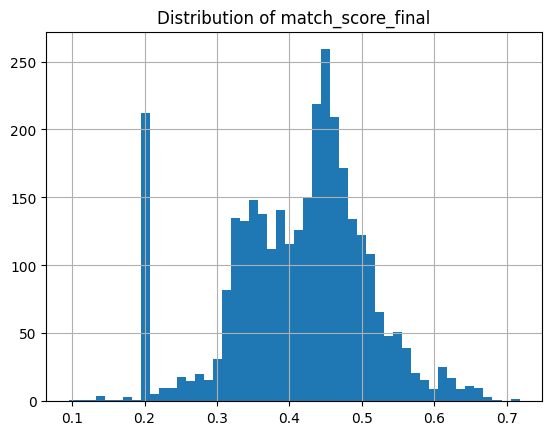

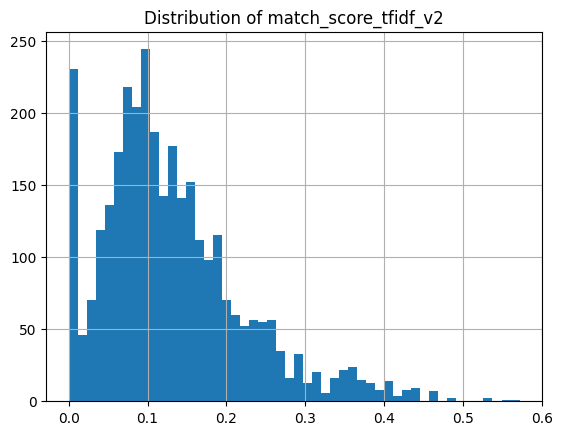

In [9]:
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure()
df["match_score_final"].hist(bins=50)
plt.title("Distribution of match_score_final")
plt.show()

plt.figure()
df["match_score_tfidf_v2"].hist(bins=50)
plt.title("Distribution of match_score_tfidf_v2")
plt.show()


In [10]:
df[df["jobtitle_raw"].str.lower().eq("member")][
    ["jobtitle_raw","jobtitle_norm","soc_code_final","match_type","match_score","mapped_role","job_category","match_score_final"]
].head(20)


,jobtitle_raw,jobtitle_norm,soc_code_final,match_type,match_score,mapped_role,job_category,match_score_final
838,Member,member,25-1122.00,fuzzy,100.0,ambassador,Admin,0.095222
